In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy as sp
import matplotlib as mpl
import seaborn as sns

# Setting up Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

# Setting up Seaborn
sns.set_style("whitegrid")
#sns.set_context("poster")

%matplotlib inline

In [2]:
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
training = train.drop('status_group', axis=1)

In [4]:
training = training.drop('Unnamed: 0', axis=1)

test = test.drop('Unnamed: 0', axis=1)

In [5]:
##Plot function for Confusion Matrix

#plt.rcParams['figure.figsize'] = (6.0, 6.0)
from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

## Because we are having maximum amount of Categorical data let us transform the features, and convert them into list

In [6]:
def transform_feature(df, column_name):
    unique_values = set(df[column_name].tolist())
    transformer_dict = {}
    for index, value in enumerate(unique_values):
        transformer_dict[value] = index
    df[column_name] = df[column_name].apply(lambda y: transformer_dict[y])
    return df

In [7]:
integer_columns = ['days_since_recorded', 'population','gps_height'] 
columns_to_transform = [col for col in training.columns if col not in integer_columns]
for column in columns_to_transform: 
    training = transform_feature(training, column)
    test = transform_feature(test, column)

## Now That we have Cleaned our dataset and Transformed our features, let us train our Model.

In [8]:
## Converting the Training dataframe into a matrix and predictor as y 
X = training.as_matrix()
y = train["status_group"].tolist()

> Splitting the Data Set with features into Train set  and Test set to train our model.

In [9]:
import sklearn.model_selection 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                                             y, 
                                                                             test_size = 0.3, 
                                                                             random_state = 0)

> As a part of EDA let us traing the data using different algorithms and findout which give us the better result.

## Random Forest Classifier

In [10]:
import sklearn.ensemble

rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, 
                                              min_samples_split=6,
                                              criterion='gini', 
                                              max_features='auto',
                                              oob_score=True,
                                              random_state=1,
                                              n_jobs=-1)

In [11]:
rfc.fit(X_train, y_train)

print('Random Forest Classifier Train Accuracy Score :', rfc.score(X_train, y_train))
print('Random Forest Classifier Test Score :', rfc.score(X_test, y_test))

Random Forest Classifier Train Accuracy Score : 0.94062049062
Random Forest Classifier Test Score : 0.804713804714


In [50]:
from sklearn.metrics import roc_curve, auc

In [51]:
y_score = rfc.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [52]:
from sklearn import metrics
import pandas as pd
from ggplot import *

preds = rfc.predict_proba(Xtest)[:,1]
fpr, tpr, _ = metrics.roc_curve(ytest, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

ModuleNotFoundError: No module named 'ggplot'

Confusion matrix
[[8650  157  805]
 [ 736  385  212]
 [1512   58 5305]]


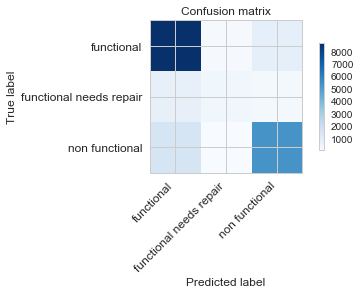

In [12]:
## Constructing the Confusion Matrix
cm = confusion_matrix(y_test, rfc.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

## Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
dtc = DecisionTreeClassifier(criterion='gini',
                            max_depth = 10,
                            max_features = 'auto',
                            random_state = 1,
                            splitter = 'best')

In [15]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [16]:
print("Train Score :", dtc.score(X_train, y_train))
print("Test Score :", dtc.score(X_test, y_test))

Train Score : 0.753222703223
Test Score : 0.727777777778


Confusion matrix
[[8449   70 1093]
 [ 940  135  258]
 [2441   49 4385]]


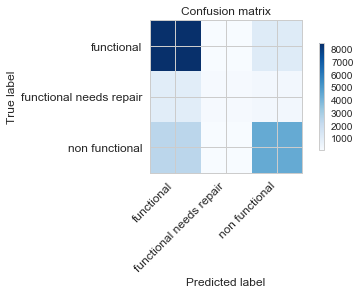

In [17]:
## Constructing the Confusion Matrix
cm = confusion_matrix(y_test, dtc.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

## Extra Tree Classifier

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

ETC = ExtraTreesClassifier(n_estimators=1000,min_samples_split=10)

In [19]:
ETC.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [20]:
print('Extra Tree Classifier Training Score :',ETC.score(X_train, y_train))
print('Extra Tree Classifier Test Score :',ETC.score(X_test, y_test))

Extra Tree Classifier Training Score : 0.911928811929
Extra Tree Classifier Test Score : 0.800448933782


Confusion matrix
[[8607  163  842]
 [ 734  387  212]
 [1544   61 5270]]


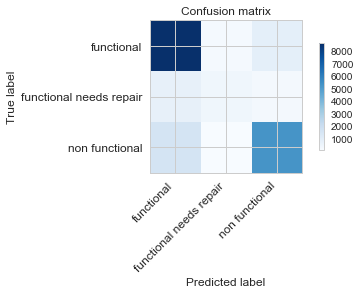

In [21]:
## Constructing the Confusion Matrix
cm = confusion_matrix(y_test, ETC.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

## Linear Search CV

In [22]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [23]:
pipe = Pipeline([('scl', StandardScaler()), ('clf', LinearSVC())])

In [24]:
param_grid = {'clf__C':[0.01],
                      'clf__class_weight':[None]}

In [25]:
estimator = GridSearchCV(estimator=pipe,
                                 param_grid=param_grid,
                                 n_jobs=-1)

In [26]:
estimator.fit(training, train.status_group)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__C': [0.01], 'clf__class_weight': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [27]:
#print(estimator.score(X_test,y_train))

estimator.score(training,train.status_group)

0.64368686868686864

## Gradient Boosting

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
test_id = pd.read_csv('SubmissionFormat.csv')
test_id.columns = ['idd', 'status_group']
test_id = test_id.idd

In [30]:
def model(X_train, X_test, y_train, y_test, test):
    if __name__ == '__main__':
    
        param_grid = {'learning_rate': [0.075,0.07],
                      'max_depth': [6,7],
                      'min_samples_leaf': [7,8],
                      'max_features': [1.0],
                      'n_estimators':[100, 200]}                      

        gbc = GridSearchCV(estimator=GradientBoostingClassifier(),
                                 param_grid=param_grid,
                                 n_jobs=-1)

        gbc.fit(X_train, y_train)

        best_params = gbc.best_params_

        print (best_params)
                                 
        validation_accuracy = gbc.score(X_test, y_test)
        print('Validation accuracy: ', validation_accuracy)
        
        predictions = gbc.predict(test)
        
        data = {'ID': test_id, 'status_group': predictions}

        submit = pd.DataFrame(data=data)

        vals_to_replace = {2:'functional', 1:'functional needs repair',
                           0:'non functional'}

        submit.status_group = submit.status_group.replace(vals_to_replace)        

        submit.to_csv('pump_predictions.csv', index=False)
        
        

In [40]:
model(X_train, X_test, y_train, y_test, test)

{'learning_rate': 0.075, 'max_depth': 7, 'max_features': 1.0, 'min_samples_leaf': 8, 'n_estimators': 200}
Validation accuracy:  0.793714927048


## Predictions

In [41]:
predict = ETC.predict(test)

In [42]:
submission = pd.read_csv('SubmissionFormat.csv')

In [43]:
Final_merge = pd.concat([test, submission], axis=1)

In [44]:
Final_merge.head()

,amount_tsh,days_since_recorded,funder,gps_height,installer,basin,subvillage,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,payment_type,water_quality,quantity_group,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group
0,0,302,1,1996,1,5,5463,321,2,9,0,2,0,2,0,5,0,1,1,2,1,50785,predicted label
1,0,302,6,1569,0,3,1988,300,2,2,321,2,6,1,0,5,1,5,0,0,0,51630,predicted label
2,0,305,1,1567,1,5,850,500,2,2,153,1,0,2,0,5,1,1,1,2,1,17168,predicted label
3,0,315,1,267,1,7,3995,250,1,2,0,2,4,2,3,5,3,0,0,2,1,45559,predicted label
4,65,251,1,1260,1,7,5933,60,1,10,1009,2,6,1,5,5,4,5,0,0,0,49871,predicted label


In [45]:
Final_merge['status_group'] = predict

In [46]:
Final_merge[['id','status_group']].to_csv('submission.csv', index=False)

In [47]:
sub = pd.read_csv('submission.csv')

In [48]:
sub.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional


In [49]:
sub.status_group.value_counts()

functional                 9157
non functional             5538
functional needs repair     155
Name: status_group, dtype: int64